# Forecasting US Inflation with Random Forests

**Paper:** https://doi.org/10.1080/07350015.2019.1637745

Import the dependencies.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

Define a function for transforming the time series.

In [2]:
def transform_series(x, tcode):
    '''
    Transform the time series.

    Parameters:
    ______________________________________________________________
    x: pandas.Series
        Time series.

    tcode: int.
        Transformation code.
    '''
    
    if tcode == 1:
        return x
    elif tcode == 2:
        return x.diff()
    elif tcode == 3:
        return x.diff().diff()
    elif tcode == 4:
        return np.log(x)
    elif tcode == 5:
        return np.log(x).diff()
    elif tcode == 6:
        return np.log(x).diff().diff()
    elif tcode == 7:
        return x.pct_change()
    else:
        raise ValueError(f"unknown `tcode` {tcode}")

Define a function for downloading and processing the data.

In [3]:
def get_data(date, target_name, target_tcode, n_lags, n_components):
    '''
    Download and process the data.

    Parameters:
    ______________________________________________________________
    date: pandas.Timestamp.
        The date of the dataset vintage.

    target_name: string.
        The name of the target time series.

    target_tcode: int.
        The transformation code of the target time series.

    n_lags: int.
        The number of autoregressive lags.

    n_components: int.
        The number of principal components.

    Returns:
    ______________________________________________________________
    train_data: pandas.DataFrame.
        The training dataset.
    
    test_data: pandas.DataFrame.
        The features needed for generating the one-month-ahead forecasts. 
    '''
    
    # get the dataset URL
    file = f"https://files.stlouisfed.org/files/htdocs/fred-md/monthly/{date.year}-{format(date.month, '02d')}.csv"
    
    # get the time series
    data = pd.read_csv(file, skiprows=[1], index_col=0)
    data.columns = [c.upper() for c in data.columns]
    
    # process the dates
    data = data.loc[pd.notna(data.index), :]
    data.index = pd.date_range(start="1959-01-01", freq="MS", periods=len(data))

    # get the transformation codes
    tcodes = pd.read_csv(file, nrows=1, index_col=0)
    tcodes.columns = [c.upper() for c in tcodes.columns]
    
    # override the target's transformation code
    tcodes[target_name] = target_tcode

    # transform the time series
    data = data.apply(lambda x: transform_series(x, tcodes[x.name].item()))

    # select the data after January 1960
    data = data[data.index >= pd.Timestamp("1960-01-01")]
    
    # drop the incomplete time series
    data = data.loc[:, data.isna().sum() == 0]

    # add the principal components
    pca = Pipeline([("scaling", StandardScaler()), ("decomposition", PCA(n_components=n_components))])
    data[[f"PC{i}" for i in range(1, 1 + n_components)]] = pca.fit_transform(data)
    
    # extract the training data
    train_data = data[[target_name]].join(data.shift(periods=list(range(1, 1 + n_lags)), suffix="_LAG")).iloc[n_lags:]
    
    # extract the test data
    test_data = data.shift(periods=list(range(0, n_lags)), suffix="_LAG").iloc[-1:]
    test_data.columns = [c.split("_LAG_")[0] + "_LAG_" + str(int(c.split("_LAG_")[1]) + 1) for c in test_data.columns]
    test_data.index += pd.offsets.MonthBegin(1)
    
    return train_data, test_data

Define a function for extracting the target values from a range of dataset vintages.

In [4]:
def get_target(start_date, end_date, target_name, target_tcode):
    '''
    Extract the target time series from a range of dataset vintages.

    Parameters:
    ______________________________________________________________
    start_date: pandas.Timestamp.
        The date of the first vintage.

    end_date: pandas.Timestamp.
        The date of the last vintage.

    target_name: str.
        The name of the target time series.

    target_tcode: int.
        The transformation code of the target time series.
    '''

    # create a data frame for storing the target values
    target = pd.DataFrame()
    
    # loop across the dataset vintages
    for date in tqdm(pd.date_range(start=start_date, end=end_date, freq="MS")):
        
        # get the dataset URL
        file = f"https://files.stlouisfed.org/files/htdocs/fred-md/monthly/{date.year}-{format(date.month, '02d')}.csv"
        
        # get the time series
        data = pd.read_csv(file, skiprows=[1], index_col=0)
        data.columns = [c.upper() for c in data.columns]

        # process the dates
        data = data.loc[pd.notna(data.index), :]
        data.index = pd.date_range(start="1959-01-01", freq="MS", periods=len(data))
        
        # select the target time series
        data = data[[target_name]]
        
        # transform the target time series
        data[target_name] = transform_series(data[target_name], target_tcode)
        
        # select the last value and save it in the data frame
        target = pd.concat([target, data.iloc[-1:]], axis=0)

    return target

Define a function for generating the forecasts over a range of dataset vintages.

In [5]:
def get_forecasts(params, start_date, end_date, target_name, target_tcode, n_lags, n_components):
    '''
    Generate the forecasts over a range of dataset vintages.

    Parameters:
    ______________________________________________________________
    params: dict.
        The random forest hyperparameters.
        
    start_date: pd.Timestamp.
        The date of the first vintage.

    end_date: pd.Timestamp.
        The date of the last vintage.

    target_name: str.
        The name of the target time series.

    target_tcode: int.
        The transformation code of the target time series.

    n_lags: int.
        The number of autoregressive lags.

    n_components: int.
        The number of principal components.
    '''

    # create a list for storing the forecasts
    forecasts = [] 
    
    # loop across the dataset vintages
    for date in tqdm(pd.date_range(start=start_date, end=end_date, freq="MS")):
        
        # get the data
        train_dataset, test_dataset = get_data(date, target_name, target_tcode, n_lags, n_components)

        # generate the forecasts
        forecasts.append(pd.DataFrame({
            "RF": run_random_forest_model(params, train_dataset, test_dataset, target_name),
            "AR": run_autoregressive_model(train_dataset, test_dataset, target_name, n_lags),
        }))

    # concatenate the forecasts in a data frame
    forecasts = pd.concat(forecasts, axis=0)
    
    return forecasts

Define a function for training the random forest model and generating the forecasts.

In [6]:
def run_random_forest_model(params, train_dataset, test_dataset, target_name):
    '''
    Run the random forest model.

    Parameters:
    ______________________________________________________________
    params: dict.
        The random forest hyperparameters.
 
    train_dataset: pandas.DataFrame.
        Training dataset.

    test_dataset: pandas.DataFrame.
        Test dataset.

    target_name: str.
        The name of the target time series.
    '''
        
    # instantiate the model
    model = RandomForestRegressor(**params)
    
    # fit the model to the training set
    model.fit(
        X=train_dataset.drop(labels=[target_name], axis=1),
        y=train_dataset[target_name]
    )
    
    # generate the forecasts over the test set
    return pd.Series(
        data=model.predict(X=test_dataset),
        index=test_dataset.index
    )

Define a function for training the autoregressive model and generating the forecasts.

In [7]:
def run_autoregressive_model(train_dataset, test_dataset, target_name, n_lags):
    '''
    Run the autoregressive model.

    Parameters:
    ______________________________________________________________
    train_dataset: pandas.DataFrame.
        Training dataset.

    test_dataset: pandas.DataFrame.
        Test dataset.

    target_name: str.
        The name of the target time series.
    
    n_lags: int.
        The number of autoregressive lags.
    '''
    
    # instantiate the model
    model = LinearRegression(fit_intercept=True)
    
    # fit the model to the training set
    model.fit(
        X=train_dataset[[f"{target_name}_LAG_{i}" for i in range(1, n_lags + 1)]],
        y=train_dataset[target_name]
    )
    
    # generate the forecasts over the test set
    return pd.Series(
        data=model.predict(X=test_dataset[[f"{target_name}_LAG_{i}" for i in range(1, n_lags + 1)]]),
        index=test_dataset.index
    )

Define the target name.

In [8]:
target_name = "CPIAUCSL"

Define the target transformation code.

In [9]:
target_tcode = 5

Define the start date of the forecasts.

In [10]:
start_date = pd.Timestamp("2023-02-01")

Define the end date of the forecasts.

In [11]:
end_date = pd.Timestamp("2024-01-01")

Generate the forecasts.

In [12]:
forecasts = get_forecasts(
    params={
        "n_estimators": 500,
        "max_features": 1 / 3,
        "min_samples_leaf": 5,
        "random_state": 42,
        "n_jobs": -1
    }, 
    start_date=start_date, 
    end_date=end_date, 
    target_name=target_name, 
    target_tcode=target_tcode,
    n_lags=4,
    n_components=4
)

100%|███████████████████████████████████████████| 12/12 [00:58<00:00,  4.89s/it]


In [13]:
forecasts

,RF,AR
2023-02-01,0.003862,0.004338
2023-03-01,0.002753,0.003232
2023-04-01,0.002187,0.001589
2023-05-01,0.003770,0.003659
2023-06-01,0.002000,0.002137
2023-07-01,0.003717,0.001967
2023-08-01,0.003591,0.002312
2023-09-01,0.005244,0.004320
2023-10-01,0.002742,0.003381
2023-11-01,0.001280,0.001676


Get the actual target values.

In [14]:
targets = get_target(
    start_date=start_date + pd.offsets.MonthBegin(1), 
    end_date=end_date + pd.offsets.MonthBegin(1), 
    target_name=target_name, 
    target_tcode=target_tcode,
)

100%|███████████████████████████████████████████| 12/12 [00:07<00:00,  1.70it/s]


In [15]:
targets

,CPIAUCSL
2023-02-01,0.003693
2023-03-01,0.000530
2023-04-01,0.003671
2023-05-01,0.001240
2023-06-01,0.001802
2023-07-01,0.001667
2023-08-01,0.006292
2023-09-01,0.003949
2023-10-01,0.000449
2023-11-01,0.000968


Visualize the forecasts.

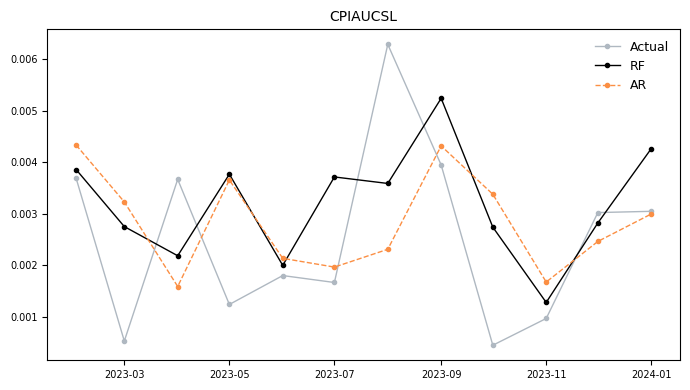

In [16]:
plt.subplots(figsize=(7, 4))
plt.plot(targets[target_name], "-o", color="#AFB8C1", lw=1, markersize=3, label="Actual")
plt.plot(forecasts["RF"], "-o", color="#000000", lw=1, markersize=3, label="RF")
plt.plot(forecasts["AR"], "o--", color="#fb8f44", lw=1, markersize=3, label="AR")
plt.tick_params(axis="both", which="major", labelsize=7)
plt.tick_params(axis="both", which="minor", labelsize=7)
plt.legend(bbox_to_anchor=(1, 0, 0, 1), frameon=False, prop={"size": 9})
plt.title(target_name, size=10)
plt.tight_layout()
plt.show()

Calculate the forecast errors.

In [17]:
errors = pd.DataFrame(
    data={
        "RF": [
            root_mean_squared_error(y_true=targets[target_name], y_pred=forecasts["RF"]),
            mean_absolute_error(y_true=targets[target_name], y_pred=forecasts["RF"]),
        ],
        "AR": [
            root_mean_squared_error(y_true=targets[target_name], y_pred=forecasts["AR"]),
            mean_absolute_error(y_true=targets[target_name], y_pred=forecasts["AR"]),
        ],
    },
    index=["RMSE", "MAE"],
)

In [18]:
errors

,RF,AR
RMSE,0.001675,0.001904
MAE,0.001389,0.001424


Calculate the percentage difference in the forecast errors.

In [19]:
errors['RF'] / errors['AR'] - 1

RMSE   -0.120193
MAE    -0.024073
dtype: float64